In [1]:
import tensorflow as tf
import numpy as np
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import utils
from augmentation import augmentation
from pointnet import PointNet, PointNet_vanilla

In [3]:
category_names = utils.get_category_names()
train_dateset_paths = utils.get_dataset_paths('train_files.txt')
test_dateset_paths = utils.get_dataset_paths('test_files.txt')

n_classes = len(category_names)
n_pts = 2048

In [4]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, n_pts, 3], name='x') # Data Points
    y = tf.placeholder(tf.int32, shape=[None], name='y') # Labels
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate') # Adaptive learning rate
    bn_decay = tf.placeholder(tf.float32, shape=[], name='bn_decay') # Adaptive batch norm decay rate
    is_training =tf.placeholder(tf.bool , shape=[], name='is_training') # Training phrase
    
# Point Net With Transform
preds = PointNet(x, n_pts, n_classes, bn_decay=bn_decay, is_training=is_training)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)) # cost function

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9).minimize(cost) # adam optimizer - update ops

evaluate = tf.equal(tf.argmax(preds, axis=1, output_type=tf.int32), y) # equivalent to provided utils.evaluate
accuracy = tf.reduce_mean(tf.cast(evaluate, tf.float32))

In [4]:
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.log_device_placement=True

batch_size = 32
n_epoch = 250
lr = 1e-3
decay = 0.5

test_every = 30
halve_lr_every = 20
increase_decay_every = 20

In [5]:
all_losses = []
init = tf.global_variables_initializer()

with tf.device('/device:GPU:0'):
    sess = tf.InteractiveSession(config = config)
    sess.run(init)
    start_time = time.time()

    for epoch in range(n_epoch):

        for datapath in train_dateset_paths:
            train_data, train_label = utils.load_h5(datapath)
            train_data, train_label, n_batch = utils.create_batch(train_data, train_label, batch_size)
            total_loss = 0.

            for i in range(n_batch):
                
                _, loss = sess.run([optimizer, cost], \
                                   feed_dict={x:augmentation(train_data[i]), y:train_label[i], \
                                              learning_rate:lr, bn_decay:decay, is_training:True})
                total_loss += loss

            total_loss /= train_data.shape[0]
            all_losses.append(total_loss)
            uptime = time.time() - start_time
            print('%dm:%ds -- [%d, %s], loss: %f' % \
                  (uptime/60, uptime%60, epoch, datapath, total_loss))

        if (epoch + 1) % halve_lr_every:
            lr /= 2
        
        if (epoch + 1) % increase_decay_every:
            decay += 0.1
            decay = 0.99 if decay > 0.99 else decay
            
        if (epoch + 1) % test_every == 0:
            print('\n')
            for datapath in test_dateset_paths:
                val_data, val_label = utils.create_val(datapath)
                print('Test %s accuracy:' % (datapath), \
                      accuracy.eval(feed_dict={x:val_data, y:val_label.reshape(-1),\
                                               bn_decay:decay, is_training:True}))
            print('\n')

0m:11s -- [0, ply_data_train0.h5], loss: 3.156831
0m:22s -- [0, ply_data_train1.h5], loss: 2.280600
0m:32s -- [0, ply_data_train2.h5], loss: 2.080329
0m:42s -- [0, ply_data_train3.h5], loss: 1.765441
0m:50s -- [0, ply_data_train4.h5], loss: 1.786995
1m:1s -- [1, ply_data_train0.h5], loss: 1.535297
1m:11s -- [1, ply_data_train1.h5], loss: 1.443524
1m:21s -- [1, ply_data_train2.h5], loss: 1.295110
1m:32s -- [1, ply_data_train3.h5], loss: 1.122914
1m:40s -- [1, ply_data_train4.h5], loss: 1.101578
1m:50s -- [2, ply_data_train0.h5], loss: 1.072540
2m:0s -- [2, ply_data_train1.h5], loss: 1.152512
2m:11s -- [2, ply_data_train2.h5], loss: 0.970947
2m:21s -- [2, ply_data_train3.h5], loss: 0.850109
2m:29s -- [2, ply_data_train4.h5], loss: 0.911579
2m:40s -- [3, ply_data_train0.h5], loss: 0.905539
2m:50s -- [3, ply_data_train1.h5], loss: 0.872264
3m:0s -- [3, ply_data_train2.h5], loss: 0.748690
3m:10s -- [3, ply_data_train3.h5], loss: 0.702984
3m:19s -- [3, ply_data_train4.h5], loss: 0.681252
3m:

26m:22s -- [31, ply_data_train4.h5], loss: 0.525774
26m:32s -- [32, ply_data_train0.h5], loss: 0.606975
26m:43s -- [32, ply_data_train1.h5], loss: 0.609618
26m:53s -- [32, ply_data_train2.h5], loss: 0.557069
27m:3s -- [32, ply_data_train3.h5], loss: 0.578946
27m:12s -- [32, ply_data_train4.h5], loss: 0.571632
27m:22s -- [33, ply_data_train0.h5], loss: 0.694133
27m:32s -- [33, ply_data_train1.h5], loss: 0.661571
27m:43s -- [33, ply_data_train2.h5], loss: 0.612206
27m:53s -- [33, ply_data_train3.h5], loss: 0.619597
28m:1s -- [33, ply_data_train4.h5], loss: 0.524599
28m:11s -- [34, ply_data_train0.h5], loss: 0.570280
28m:22s -- [34, ply_data_train1.h5], loss: 0.623326
28m:32s -- [34, ply_data_train2.h5], loss: 0.578967
28m:42s -- [34, ply_data_train3.h5], loss: 0.539966
28m:50s -- [34, ply_data_train4.h5], loss: 0.558292
29m:1s -- [35, ply_data_train0.h5], loss: 0.598961
29m:11s -- [35, ply_data_train1.h5], loss: 0.565011
29m:21s -- [35, ply_data_train2.h5], loss: 0.577648
29m:32s -- [35,

52m:15s -- [63, ply_data_train1.h5], loss: 0.602242
52m:26s -- [63, ply_data_train2.h5], loss: 0.612224
52m:36s -- [63, ply_data_train3.h5], loss: 0.528530
52m:44s -- [63, ply_data_train4.h5], loss: 0.499613
52m:54s -- [64, ply_data_train0.h5], loss: 0.677104
53m:5s -- [64, ply_data_train1.h5], loss: 0.635799
53m:15s -- [64, ply_data_train2.h5], loss: 0.593910
53m:25s -- [64, ply_data_train3.h5], loss: 0.584605
53m:33s -- [64, ply_data_train4.h5], loss: 0.547310
53m:44s -- [65, ply_data_train0.h5], loss: 0.569497
53m:54s -- [65, ply_data_train1.h5], loss: 0.608431
54m:4s -- [65, ply_data_train2.h5], loss: 0.604322
54m:15s -- [65, ply_data_train3.h5], loss: 0.524033
54m:23s -- [65, ply_data_train4.h5], loss: 0.551578
54m:33s -- [66, ply_data_train0.h5], loss: 0.593688
54m:43s -- [66, ply_data_train1.h5], loss: 0.616934
54m:54s -- [66, ply_data_train2.h5], loss: 0.654409
55m:4s -- [66, ply_data_train3.h5], loss: 0.551100
55m:12s -- [66, ply_data_train4.h5], loss: 0.490248
55m:22s -- [67,

78m:7s -- [94, ply_data_train3.h5], loss: 0.562164
78m:15s -- [94, ply_data_train4.h5], loss: 0.549056
78m:25s -- [95, ply_data_train0.h5], loss: 0.659560
78m:35s -- [95, ply_data_train1.h5], loss: 0.602084
78m:46s -- [95, ply_data_train2.h5], loss: 0.589223
78m:56s -- [95, ply_data_train3.h5], loss: 0.554219
79m:4s -- [95, ply_data_train4.h5], loss: 0.555534
79m:15s -- [96, ply_data_train0.h5], loss: 0.667645
79m:25s -- [96, ply_data_train1.h5], loss: 0.606090
79m:35s -- [96, ply_data_train2.h5], loss: 0.600999
79m:46s -- [96, ply_data_train3.h5], loss: 0.568172
79m:54s -- [96, ply_data_train4.h5], loss: 0.556395
80m:4s -- [97, ply_data_train0.h5], loss: 0.651593
80m:14s -- [97, ply_data_train1.h5], loss: 0.674179
80m:25s -- [97, ply_data_train2.h5], loss: 0.583810
80m:35s -- [97, ply_data_train3.h5], loss: 0.550787
80m:43s -- [97, ply_data_train4.h5], loss: 0.523358
80m:53s -- [98, ply_data_train0.h5], loss: 0.592662
81m:4s -- [98, ply_data_train1.h5], loss: 0.626110
81m:14s -- [98, 

103m:27s -- [125, ply_data_train2.h5], loss: 0.564890
103m:38s -- [125, ply_data_train3.h5], loss: 0.646002
103m:46s -- [125, ply_data_train4.h5], loss: 0.546919
103m:56s -- [126, ply_data_train0.h5], loss: 0.636109
104m:7s -- [126, ply_data_train1.h5], loss: 0.558170
104m:17s -- [126, ply_data_train2.h5], loss: 0.599206
104m:27s -- [126, ply_data_train3.h5], loss: 0.517505
104m:35s -- [126, ply_data_train4.h5], loss: 0.512443
104m:46s -- [127, ply_data_train0.h5], loss: 0.594330
104m:56s -- [127, ply_data_train1.h5], loss: 0.658852
105m:6s -- [127, ply_data_train2.h5], loss: 0.565078
105m:16s -- [127, ply_data_train3.h5], loss: 0.524529
105m:24s -- [127, ply_data_train4.h5], loss: 0.519070
105m:35s -- [128, ply_data_train0.h5], loss: 0.654529
105m:45s -- [128, ply_data_train1.h5], loss: 0.650401
105m:55s -- [128, ply_data_train2.h5], loss: 0.585615
106m:6s -- [128, ply_data_train3.h5], loss: 0.608858
106m:14s -- [128, ply_data_train4.h5], loss: 0.523489
106m:24s -- [129, ply_data_trai

128m:18s -- [155, ply_data_train3.h5], loss: 0.556464
128m:26s -- [155, ply_data_train4.h5], loss: 0.566216
128m:37s -- [156, ply_data_train0.h5], loss: 0.637744
128m:47s -- [156, ply_data_train1.h5], loss: 0.660551
128m:57s -- [156, ply_data_train2.h5], loss: 0.628468
129m:7s -- [156, ply_data_train3.h5], loss: 0.525121
129m:16s -- [156, ply_data_train4.h5], loss: 0.504445
129m:26s -- [157, ply_data_train0.h5], loss: 0.605128
129m:36s -- [157, ply_data_train1.h5], loss: 0.641442
129m:46s -- [157, ply_data_train2.h5], loss: 0.521488
129m:57s -- [157, ply_data_train3.h5], loss: 0.569215
130m:5s -- [157, ply_data_train4.h5], loss: 0.571649
130m:15s -- [158, ply_data_train0.h5], loss: 0.564911
130m:26s -- [158, ply_data_train1.h5], loss: 0.598536
130m:36s -- [158, ply_data_train2.h5], loss: 0.604702
130m:46s -- [158, ply_data_train3.h5], loss: 0.596063
130m:54s -- [158, ply_data_train4.h5], loss: 0.547295
131m:5s -- [159, ply_data_train0.h5], loss: 0.598591
131m:15s -- [159, ply_data_trai

153m:9s -- [185, ply_data_train4.h5], loss: 0.543234
153m:19s -- [186, ply_data_train0.h5], loss: 0.592039
153m:29s -- [186, ply_data_train1.h5], loss: 0.591332
153m:39s -- [186, ply_data_train2.h5], loss: 0.577896
153m:50s -- [186, ply_data_train3.h5], loss: 0.530727
153m:58s -- [186, ply_data_train4.h5], loss: 0.609139
154m:8s -- [187, ply_data_train0.h5], loss: 0.598105
154m:18s -- [187, ply_data_train1.h5], loss: 0.579355
154m:29s -- [187, ply_data_train2.h5], loss: 0.634276
154m:39s -- [187, ply_data_train3.h5], loss: 0.526585
154m:47s -- [187, ply_data_train4.h5], loss: 0.531512
154m:57s -- [188, ply_data_train0.h5], loss: 0.618086
155m:8s -- [188, ply_data_train1.h5], loss: 0.606042
155m:18s -- [188, ply_data_train2.h5], loss: 0.627613
155m:28s -- [188, ply_data_train3.h5], loss: 0.536174
155m:37s -- [188, ply_data_train4.h5], loss: 0.485472
155m:47s -- [189, ply_data_train0.h5], loss: 0.626097
155m:57s -- [189, ply_data_train1.h5], loss: 0.633110
156m:7s -- [189, ply_data_train

178m:0s -- [216, ply_data_train0.h5], loss: 0.653777
178m:10s -- [216, ply_data_train1.h5], loss: 0.589061
178m:20s -- [216, ply_data_train2.h5], loss: 0.605120
178m:31s -- [216, ply_data_train3.h5], loss: 0.604092
178m:39s -- [216, ply_data_train4.h5], loss: 0.529444
178m:49s -- [217, ply_data_train0.h5], loss: 0.646936
178m:59s -- [217, ply_data_train1.h5], loss: 0.577439
179m:10s -- [217, ply_data_train2.h5], loss: 0.658706
179m:20s -- [217, ply_data_train3.h5], loss: 0.584338
179m:28s -- [217, ply_data_train4.h5], loss: 0.548448
179m:38s -- [218, ply_data_train0.h5], loss: 0.633057
179m:49s -- [218, ply_data_train1.h5], loss: 0.570112
179m:59s -- [218, ply_data_train2.h5], loss: 0.541003
180m:9s -- [218, ply_data_train3.h5], loss: 0.511502
180m:17s -- [218, ply_data_train4.h5], loss: 0.597353
180m:28s -- [219, ply_data_train0.h5], loss: 0.655015
180m:38s -- [219, ply_data_train1.h5], loss: 0.570375
180m:48s -- [219, ply_data_train2.h5], loss: 0.599077
180m:58s -- [219, ply_data_tra

202m:51s -- [246, ply_data_train1.h5], loss: 0.581121
203m:2s -- [246, ply_data_train2.h5], loss: 0.523761
203m:12s -- [246, ply_data_train3.h5], loss: 0.508726
203m:20s -- [246, ply_data_train4.h5], loss: 0.551150
203m:30s -- [247, ply_data_train0.h5], loss: 0.634172
203m:41s -- [247, ply_data_train1.h5], loss: 0.681204
203m:51s -- [247, ply_data_train2.h5], loss: 0.541380
204m:1s -- [247, ply_data_train3.h5], loss: 0.534176
204m:9s -- [247, ply_data_train4.h5], loss: 0.550889
204m:20s -- [248, ply_data_train0.h5], loss: 0.587642
204m:30s -- [248, ply_data_train1.h5], loss: 0.638150
204m:40s -- [248, ply_data_train2.h5], loss: 0.576419
204m:50s -- [248, ply_data_train3.h5], loss: 0.504000
204m:59s -- [248, ply_data_train4.h5], loss: 0.598065
205m:9s -- [249, ply_data_train0.h5], loss: 0.595246
205m:19s -- [249, ply_data_train1.h5], loss: 0.644212
205m:29s -- [249, ply_data_train2.h5], loss: 0.646009
205m:40s -- [249, ply_data_train3.h5], loss: 0.574823
205m:48s -- [249, ply_data_train

In [6]:
print('\n\nAfter Training:')

for datapath in train_dateset_paths:
    train_data, train_label = utils.create_val(datapath)
    print('Train %s accuracy:' % (datapath), \
      accuracy.eval(feed_dict={x:train_data, y:train_label.reshape(-1),\
                               bn_decay:0.99, is_training:False}))

for datapath in test_dateset_paths:
    test_data, test_label = utils.create_val(datapath)
    print('Test %s accuracy:' % (datapath), \
      accuracy.eval(feed_dict={x:test_data, y:test_label.reshape(-1),\
                               bn_decay:0.99, is_training:False}))



After Training:
('Train ply_data_train0.h5 accuracy:', 0.88235295)
('Train ply_data_train1.h5 accuracy:', 0.89215684)
('Train ply_data_train2.h5 accuracy:', 0.9019608)
('Train ply_data_train3.h5 accuracy:', 0.89215684)
('Train ply_data_train4.h5 accuracy:', 0.91463417)
('Test ply_data_test0.h5 accuracy:', 0.85294116)
('Test ply_data_test1.h5 accuracy:', 0.9047619)


In [7]:
saver = tf.train.Saver()
saver.save(sess, "model/PointNet_300epoch.ckpt")
sess.close()

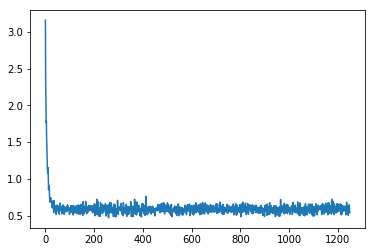

In [8]:
plt.figure()
plt.plot(all_losses)